In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt 
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import calendar
import xgboost as xgb
%matplotlib inline

In [280]:
train = pd.DataFrame.from_csv('./data/train.csv')
test = pd.DataFrame.from_csv('./data/test.csv')
print('Train : {}, Test : {}'.format(len(train), len(test)))
df_all = pd.concat([train, test])
df_all = df_all.reset_index()

Train : 1458644, Test : 625134


In [281]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance_manhattan(lon1, lat1, lon2, lat2):
    a = haversine_np(lon1, lat1, lon2, lat1)
    b = haversine_np(lon1, lat1, lon1, lat2)
    return a+b

def bearing_array(lon1, lat1, lon2, lat2):
    lon_delta_rad = np.radians(lon2 - lon1)
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    y = np.sin(lon_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [282]:
def get_time_stats(df):
    df["year"] = pd.to_datetime(df['pickup_datetime']).dt.year
    df["month"] = pd.to_datetime(df['pickup_datetime']).dt.month
    df["day"] = pd.to_datetime(df['pickup_datetime']).dt.weekday
    df["pickup_hour"] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['pickup_minute'] = pd.to_datetime(df['pickup_datetime']).dt.minute
    df['pickup_weekofyear'] = pd.to_datetime(df['pickup_datetime']).dt.weekofyear
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime']).dt.date
    return df

def get_distances(df):
    # Looping through arrays of data is very slow in python. 
    # Numpy provides functions that operate on entire arrays of data, 
    # which lets you avoid looping and drastically improve performance
    df['distance'] = haversine_np(df['pickup_longitude'],
                                     df['pickup_latitude'],
                                     df['dropoff_longitude'],
                                     df['dropoff_latitude'])
    df['distance_manhattan'] = distance_manhattan(df['pickup_longitude'],
                                                     df['pickup_latitude'],
                                                     df['dropoff_longitude'],
                                                     df['dropoff_latitude'])
    df['bearing'] = bearing_array(df['pickup_longitude'],
                                     df['pickup_latitude'],
                                     df['dropoff_longitude'],
                                     df['dropoff_latitude'])
    df["mean_speed"] = (df.distance / df.trip_duration)*3600
    df['alone'] = (df['passenger_count']==1).apply(int)
    df['center_latitude'] = (df['pickup_latitude'] + df['dropoff_latitude']) / 2
    df['center_longitude'] = (df['pickup_longitude'] + df['dropoff_longitude']) / 2
    return df

In [283]:
df_all = get_time_stats(df_all)
df_all = get_distances(df_all)

### Distributions

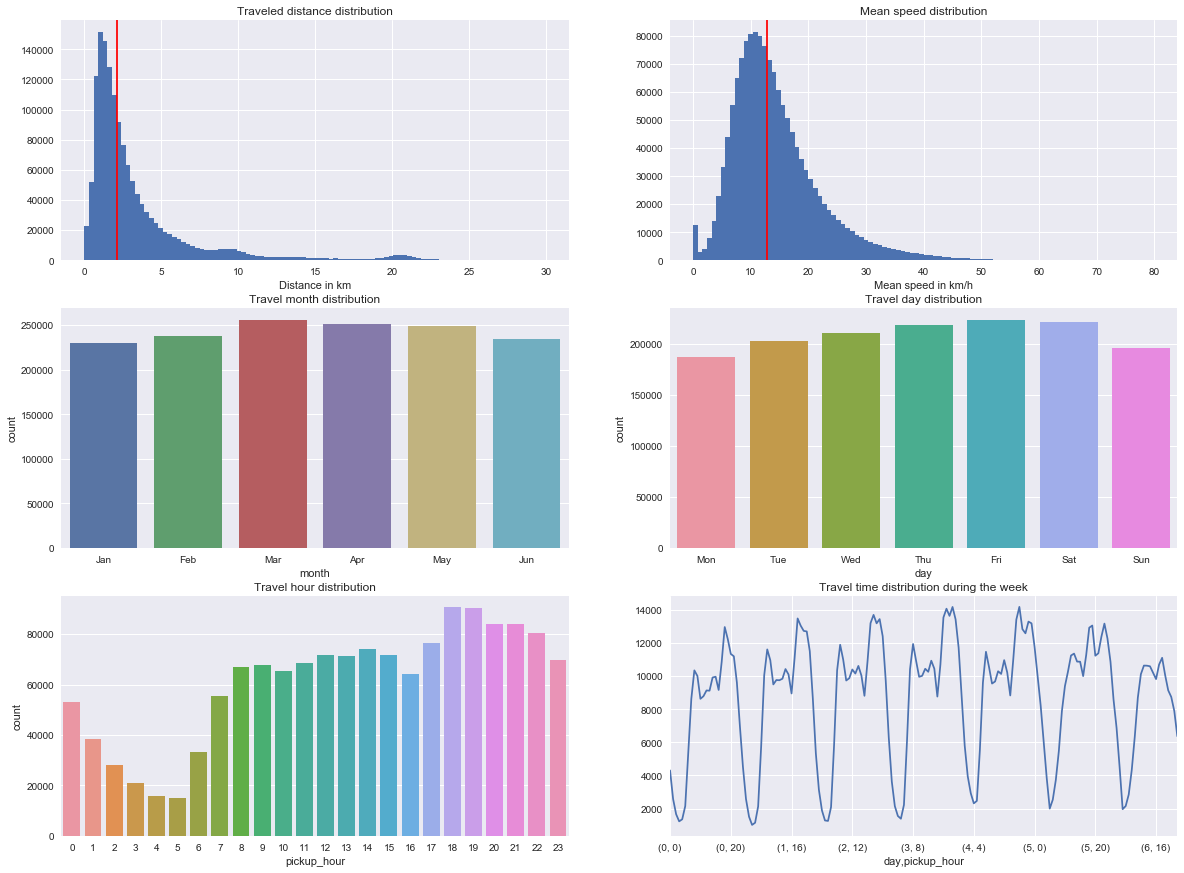

In [61]:
f, ax = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
train[train.distance < 30].distance.hist(bins=100, ax=ax[0,0])
ax[0, 0].axvline(train[train.distance < 30].distance.median(), color='red')
ax[0, 0].set_xlabel('Distance in km')
ax[0, 0].set_title('Traveled distance distribution')

train[train.mean_speed < 80].mean_speed.hist(bins=100, ax=ax[0,1])
ax[0, 1].axvline(train[train.mean_speed < 80].mean_speed.median(), color='red')
ax[0, 1].set_xlabel('Mean speed in km/h')
ax[0, 1].set_title('Mean speed distribution')

sns.countplot(train.month, ax =ax[1,0])
_ = ax[1,0].set_xticklabels([calendar.month_abbr[int(k.get_text())] for k in ax[1,0].get_xticklabels()])
ax[1, 0].set_title('Travel month distribution')

sns.countplot(train.day, ax =ax[1,1])
_ = ax[1,1].set_xticklabels([calendar.day_abbr[int(k.get_text())] for k in ax[1,1].get_xticklabels()])
ax[1, 1].set_title('Travel day distribution')

sns.countplot(train.pickup_hour, ax =ax[2,0])
ax[2, 0].set_title('Travel hour distribution')

train.groupby(['day', 'pickup_hour']).count()['vendor_id'].plot(ax=ax[2,1])
ax[2, 1].set_title('Travel time distribution during the week')

### Trip duration

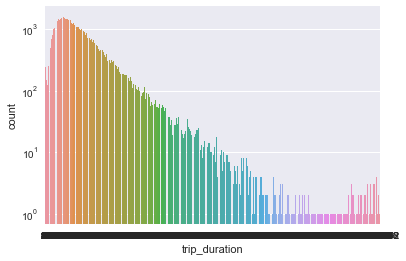

In [10]:
sns.countplot('trip_duration', data=train)
plt.yscale('log')

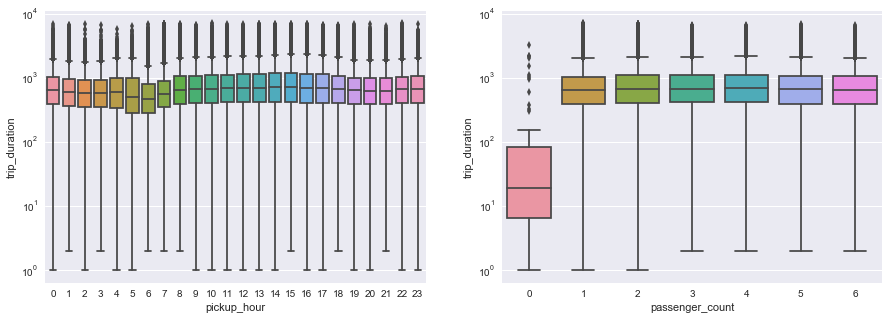

In [103]:
f, ax = plt.subplots(ncols=2, figsize=(15,5))
sns.boxplot(x='pickup_hour', y='trip_duration', data=train[train.trip_duration < 2*3600], ax = ax[0])
sns.boxplot(x='passenger_count', y='trip_duration', data=train[(train.trip_duration < 2*3600) & 
                                                               (train.passenger_count < 7)], ax = ax[1])
ax[1].set_yscale('log')
ax[0].set_yscale('log')

### Loneliness

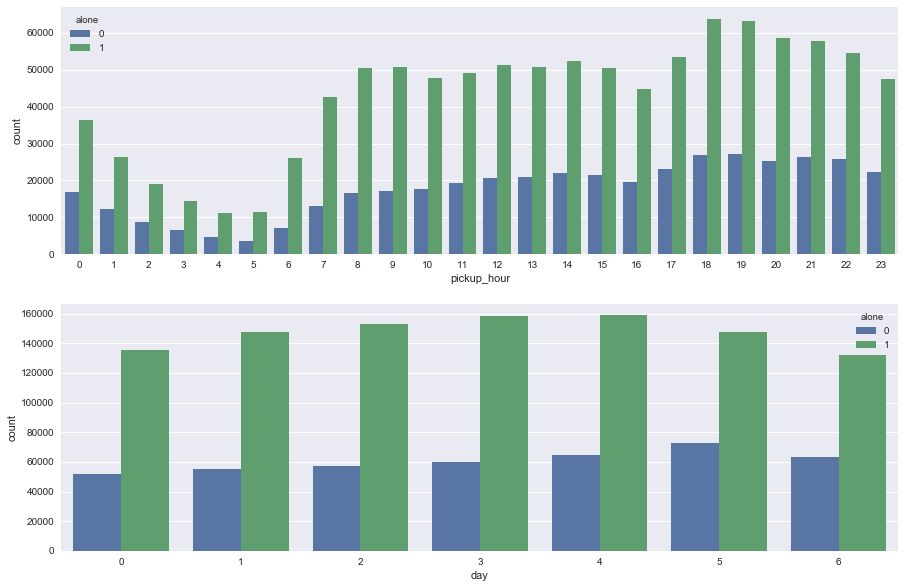

In [33]:
f, ax = plt.subplots(nrows=2, figsize=(15,10))
sns.countplot('pickup_hour', hue='alone', data=train, ax=ax[0])
sns.countplot('day', hue='alone', data=train, ax=ax[1])

People seems to travel lonely on week day and on the morning/evening, those taxi trips should be to go to work.  

### Vendor id

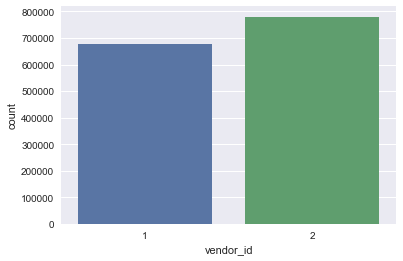

In [40]:
_ = sns.countplot('vendor_id', data=train)

There are more trip with vendor 2. Let's see, if the `vendor_id` has an influence on distributions.   
As there are more trips with vendor 2, if the vendor has no influence, distribution should be a little more important for vendor 2.

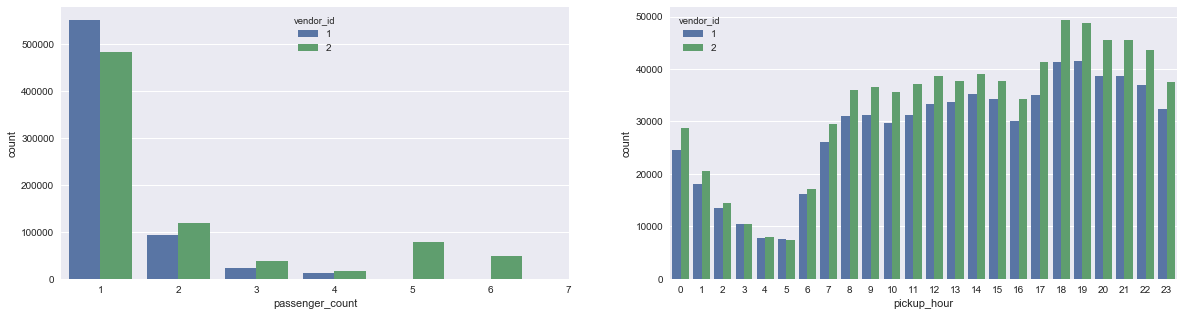

In [44]:
f, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.countplot("passenger_count", hue='vendor_id', data=train, ax =ax[0])
_ = ax[0].set_xlim([0.5, 7])

sns.countplot("pickup_hour", hue='vendor_id', data=train, ax =ax[1])

1. As you can see,  almost all the big cars (>= 5 passengers) belong to vendor 2. Vendor 2 should have a bigger car.  
While vendor seems busy with trip with many passengers, vendor 1 take more lonely passengers.
  
2. The passenger count doesn't seem to influence the pick up hour. Altough, people are more traveling with vendor 1 in proportion in the night (3-6am).


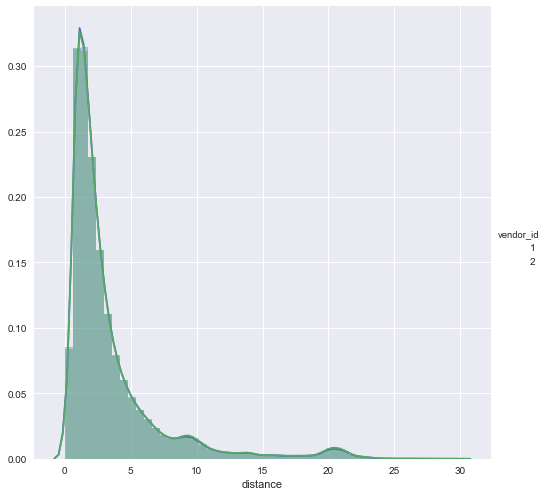

In [92]:
g =sns.FacetGrid(train[train.distance < 30], hue="vendor_id", size=7)
g = g.map(sns.distplot, "distance")
g.add_legend({'green': 'vendor 1', 'blue':"vendor 2"})

No influence of the `vendor id` on the traveled distance

### Traffic

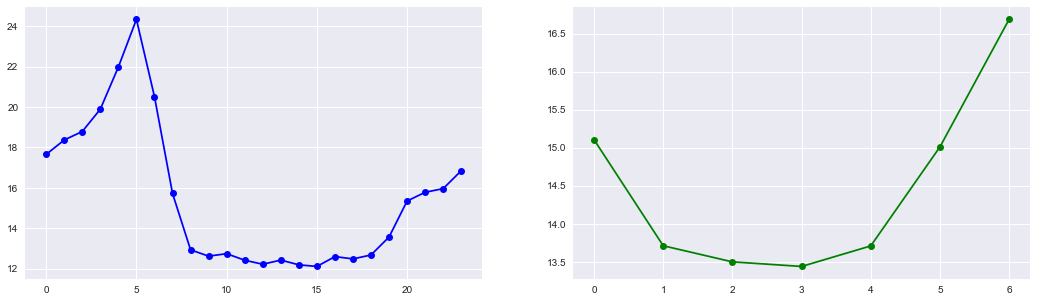

In [47]:
f, ax = plt.subplots(ncols=2, figsize=(18,5))
ax[0].plot(train.groupby('pickup_hour').mean()['mean_speed'], 'bo-')
ax[1].plot(train.groupby('day').mean()['mean_speed'], 'go-')

As we can see, traffic is more important during the day (8-19) and the week day (Monday-Friday).

### Cleaning extreme trips

In [17]:
for k in [0.5, 1, 5, 10, 20, 100]:
    print("{} hours+ trips : {:.4f} %".format(k, (len(train[train.trip_duration > k * 3600]) / len(train))*100))

0.5hours+ trips : 7.7550 %
1hours+ trips : 0.8444 %
5hours+ trips : 0.1420 %
10hours+ trips : 0.1379 %
20hours+ trips : 0.1325 %
100hours+ trips : 0.0003 %


99% of the trips are less than one hour.

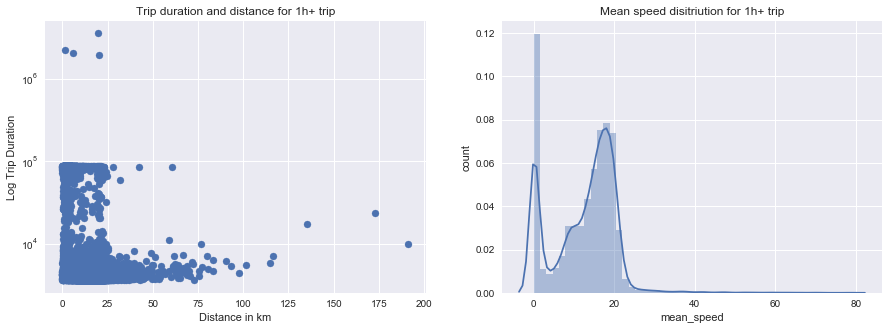

In [28]:
extreme = train[train.trip_duration > 3600]
f, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].scatter(extreme.distance, extreme.trip_duration)
ax[0].set_yscale('log')
ax[0].set_ylabel('Log Trip Duration')
ax[0].set_xlabel('Distance in km')
ax[0].set_title('Trip duration and distance for 1h+ trip')

sns.distplot(extreme['mean_speed'], ax=ax[1])
ax[1].set_ylabel('count')
ax[1].set_title('Mean speed disitriution for 1h+ trip')

There are some odd long (>1h) trips with a mean speed closed to 0 km/h and some trips with a distance closed to 0 km but with a trip duration > 1h ...

In [32]:
print('The mean trip duration for 1h+ trip with a speed < 1 km/h is {:.2f} hour'.format(extreme[extreme.mean_speed < 1].trip_duration.mean()/3600))

The mean trip duration for 1h+ trip with a speed < 1 km/h is 22.43 hour


For ~1 day trip seems unreal and they need to be removed. So, i will remove 20h+ trips (<0.15% of the database).

### PCA

In [284]:
coords = np.vstack((df_all[['pickup_latitude', 'pickup_longitude']].values,
                    df_all[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
for k in range(2):
    df_all['pickup_pca%s' % k] = pca.transform(df_all[['pickup_latitude', 
                                                     'pickup_longitude']])[:, k]
    df_all['dropoff_pca%s' % k] = pca.transform(df_all[['dropoff_latitude', 
                                                        'dropoff_longitude']])[:, k]

In [285]:
df_all['pca_manhattan'] = np.abs(df_all['dropoff_pca1'] - df_all['pickup_pca1']) +\
                                np.abs(df_all['dropoff_pca0'] - df_all['pickup_pca0'])

### Clustering

In [286]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [287]:
df_all['pickup_cluster'] = kmeans.predict(df_all[['pickup_latitude', 'pickup_longitude']])
df_all['dropoff_cluster'] = kmeans.predict(df_all[['dropoff_latitude', 'dropoff_longitude']])

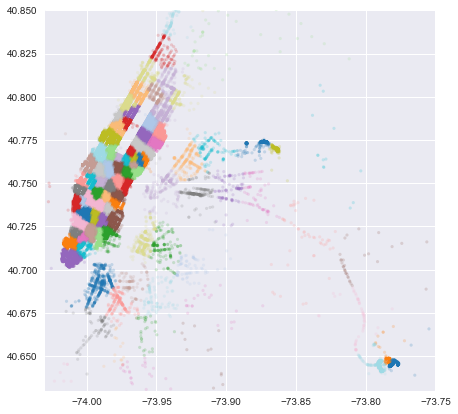

In [288]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(7,7))
plt.scatter(df_all.pickup_longitude.values[:N], df_all.pickup_latitude.values[:N], s=10, lw=0,
           c=df_all.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
_ = plt.xlim(city_long_border)
_ = plt.ylim(city_lat_border)

In [289]:
# Time aggregation for each cluster
for gby_col in ['pickup_hour', 'pickup_date', 
                'pickup_cluster', 'dropoff_cluster']:
    gby = df_all.groupby(gby_col).mean()[['mean_speed', 'trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    df_all = pd.merge(df_all, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = df_all.groupby(gby_cols).mean()[['mean_speed']].reset_index()
    coord_count = df_all.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['mean_speed_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    df_all = pd.merge(df_all, coord_stats, how='left', on=gby_cols)

In [290]:
df_all['trip_over_1h'] = (df_all.trip_duration > 3600).apply(int)
for t in ['pickup', 'dropoff']:
    k = df_all.groupby('%s_cluster' % t ).sum()[['trip_over_1h']].reset_index()
    k.columns = ['%s_cluster' % t, '%s_cluster_trip_over_1h' %t]
    df_all = pd.merge(df_all, k, on = '%s_cluster' % t)

### Training

In [291]:
for col in ['mean_speed_pickup_hour_pickup_cluster','cnt_pickup_hour_pickup_cluster' ,
            'mean_speed_pickup_hour_dropoff_cluster','cnt_pickup_hour_dropoff_cluster',
            'mean_speed_pickup_cluster_dropoff_cluster','cnt_pickup_cluster_dropoff_cluster']:
    df_all[col] = df_all[col].fillna(df_all[col].mean())

In [292]:
df = df_all.drop(['pickup_date', 'trip_over_1h'], axis=1)
le = LabelEncoder()
df.store_and_fwd_flag = le.fit_transform(df.store_and_fwd_flag)
temp = df.set_index('id')
df_train = temp.loc[np.array(train.index)]
df_test = temp.loc[np.array(test.index)]
df_train = df_train[df_train.trip_duration < 5*3600]

In [293]:
do_not_use_for_training = ['id', 'trip_duration', 'pickup_datetime', 
                           'dropoff_datetime', 'mean_speed','year',
                          'pickup_date']
feature_names = [f for f in df_train.columns if f not in do_not_use_for_training]
print('We have %i features.' % len(feature_names))
y = np.log(df_train['trip_duration'].values + 1)
X = df_train[feature_names].values

X_test = df_test[feature_names].values

We have 41 features.


#### XGBoost

In [294]:
Xtr, Xv, ytr, yv = train_test_split(X, 
                                    y, 
                                    test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
xgb_pars = {'min_child_weight': 50, 'eta': 0.25, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)            

[0]	train-rmse:4.51732	valid-rmse:4.5161
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:0.345058	valid-rmse:0.359098
[40]	train-rmse:0.327496	valid-rmse:0.348587
[60]	train-rmse:0.318606	valid-rmse:0.345199
[80]	train-rmse:0.312997	valid-rmse:0.343443
[100]	train-rmse:0.308717	valid-rmse:0.342073
[120]	train-rmse:0.305674	valid-rmse:0.342051
[140]	train-rmse:0.302194	valid-rmse:0.341949
Stopping. Best iteration:
[105]	train-rmse:0.307601	valid-rmse:0.341773



In [295]:
dtest = xgb.DMatrix(df_test[feature_names].values)
ytest = model.predict(dtest)
df_test['trip_duration'] = np.exp(ytest) - 1
df_test.reset_index()[['id', 'trip_duration']].to_csv('attia_xgb_submission.csv', 
                                     index=False)

In [216]:
## Score on Kaggle : 0.392

#### Random Forest

In [ ]:
clf = RandomForestRegressor()
clf.fit(X, y)

In [211]:
print('RMSE', mean_squared_error(y, clf.predict(X))**0.5)

In [213]:
ytest = clf.predict(X_test)
df_test['trip_duration'] = np.exp(ytest) - 1
df_test.reset_index()[['id','trip_duration']].to_csv('submission.csv', index=False)

In [214]:
## Score on Kaggle : 0.414

### Feature importance

In [28]:
## Do 2D graph with RF and XGB boost

In [189]:
feat_importances_rf = dict(zip(X.columns[np.argsort(clf.feature_importances_)[::-1]], 
                        np.sort(clf.feature_importances_)[::-1]))

In [273]:
name_map = dict(zip(['f%i' % i for i in range(len(feature_names))], feature_names))
feat_importances_xgb = {name_map[k]:v/sum(model.get_fscore().values()) 
                        for k,v in model.get_fscore().items()}

In [274]:
feat_importance = pd.DataFrame({'name':list(feat_importances_rf.keys()), 
                               'rf': list(feat_importances_rf.values())})
feat_importance['xgb'] = feat_importance['name'].map(feat_importances_xgb)
feat_importance['sum'] = (feat_importance['xgb'] + feat_importance['rf']) / 2
feat_importance = feat_importance.sort_values('sum', ascending=False)

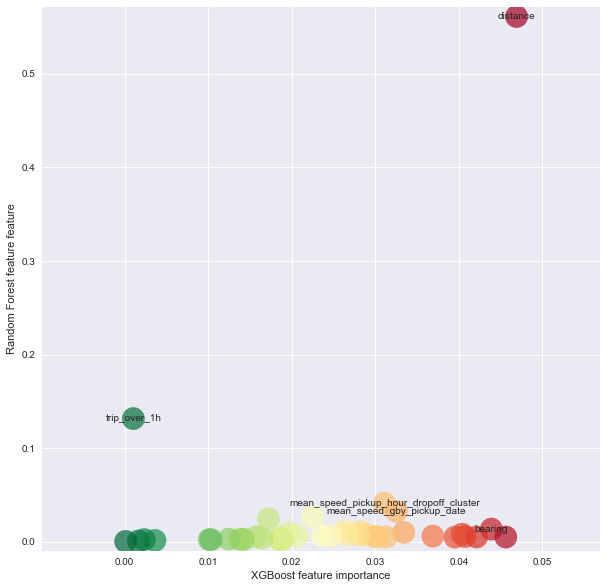

In [275]:
sns.axes_style("whitegrid")
plt.figure(figsize=(10,10))
plt.scatter(feat_importance['xgb'].values, 
            feat_importance['rf'].values,
            c=feat_importance['xgb'].values, 
            s=500, cmap='RdYlGn_r', alpha=0.7)
for _, row in feat_importance.head(5).iterrows():
    plt.text(row['xgb'], row['rf'], row['name'],
            verticalalignment='center', horizontalalignment='center')
plt.xlabel('XGBoost feature importance')
plt.ylabel('Random Forest feature feature')
plt.ylim(np.min(feat_importance['rf'].values) - 0.01, 
            np.max(feat_importance['rf'].values) + 0.01)
_ = plt.xlim(np.min(feat_importance['xgb'].values) - 0.01, 
            np.max(feat_importance['xgb'].values) + 0.01)